In [1]:
import os
import urllib
import pandas as pd
import numpy as np
from numpy.random import uniform, binomial
from sklearn.model_selection import KFold
import math
import matplotlib.pyplot as plt
import time

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_probability as tfp
tfd = tfp.distributions

# To remove WARNINGS from saving the models without compiling them first
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#print(tf.__version__)
#print(tf.test.gpu_device_name())

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())

#Working with CPU for now...

Num GPUs Available:  0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
from __future__ import division
import datetime
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from random import seed
#from .UCI_loader import unnormalise_cat_vars


# TODO return mean and std for variables + train test split

"""
def check_data_file(fname):
    files = os.listdir(".")  # get the current directory listing
    print
    "Looking for file '%s' in the current directory..." % fname

    if fname not in files:
        print
        "'%s' not found! Downloading from GitHub..." % fname
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        try:
            response = urllib2.urlopen(addr)
        except:
            response = urllib3.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "w")
        fileOut.write(data)
        fileOut.close()
        print
        "'%s' download and saved locally.." % fname
    else:
        print
        "File found in current directory.."
"""

def check_data_file(fname):
    files = os.listdir(".")  # get the current directory listing
    print
    "Looking for file '%s' in the current directory..." % fname

    if fname not in files:
        print
        "'%s' not found! Downloading from GitHub..." % fname
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        
        response = urllib.request.urlopen(addr)

        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print
        "'%s' download and saved locally.." % fname
    else:
        print
        "File found in current directory.."

def get_my_COMPAS(rseed=0, separate_test=True, test_ratio=0.2, save_dir='../data/'):
    """
        The adult dataset can be obtained from: https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
        The code will look for the data file in the present directory, if it is not found, it will download them from GitHub.
    """

    SEED = rseed
    seed(SEED)
    np.random.seed(SEED)

    their_FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "priors_count", "c_charge_degree"]
    FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "c_charge_degree", "is_recid", "priors_count",
                               "time_served"]  # features to be used for classification
    CONT_VARIABLES = ["priors_count",
                      "time_served"]  # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
    CLASS_FEATURE = "two_year_recid"  # the decision variable


    COMPAS_INPUT_FILE = save_dir + "compas-scores-two-years.csv"
    check_data_file(COMPAS_INPUT_FILE)

    # load the data and get some stats
    df = pd.read_csv(COMPAS_INPUT_FILE)
    df = df.dropna(subset=["days_b_screening_arrest"])  # dropping missing vals

    # convert to np array
    data = df.to_dict('list')
    for k in data.keys():
        data[k] = np.array(data[k])

    dates_in = data['c_jail_in']
    dates_out = data['c_jail_out']
    # this measures time in Jail
    time_served = []
    for i in range(len(dates_in)):
        di = datetime.datetime.strptime(dates_in[i], '%Y-%m-%d %H:%M:%S')
        do = datetime.datetime.strptime(dates_out[i], '%Y-%m-%d %H:%M:%S')
        time_served.append((do - di).days)
    time_served = np.array(time_served)
    time_served[time_served < 0] = 0
    data["time_served"] = time_served

    """ Filtering the data """

    # These filters are the same as propublica (refer to https://github.com/propublica/compas-analysis)
    # If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
    idx = np.logical_and(data["days_b_screening_arrest"] <= 30, data["days_b_screening_arrest"] >= -30)

    # We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
    idx = np.logical_and(idx, data["is_recid"] != -1)

    # In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
    idx = np.logical_and(idx, data["c_charge_degree"] != "O")  # F: felony, M: misconduct

    # We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.
    idx = np.logical_and(idx, data["score_text"] != "NA")

    # select the examples that satisfy this criteria
    for k in data.keys():
        data[k] = data[k][idx]

    y = data[CLASS_FEATURE]
    """ Feature normalization and one hot encoding """

    print
    "\nNumber of people recidivating within two years"
    print
    pd.Series(y).value_counts()
    print
    "\n"

    X = []  # empty array with num rows same as num examples, will hstack the features to it
    X_dims = []

    feature_names = []
    for attr in FEATURES_CLASSIFICATION:
        vals = data[attr]
        if attr in CONT_VARIABLES:
            vals = [float(v) for v in vals]
            # vals = preprocessing.scale(vals, axis=0, with_mean=True, with_std=True)  # 0 mean and 1 variance
            vals = np.reshape(vals, (len(y), -1))  # convert from 1-d arr to a 2-d arr with one col
            X_dims.append(1)

        else:  # for binary categorical variables, the label binarizer uses just one var instead of two
            enc = preprocessing.OneHotEncoder(categories='auto', handle_unknown='error')
            enc.fit(vals.reshape(-1, 1))
            vals = enc.transform(vals.reshape(-1, 1)).todense()
            X_dims += [vals.shape[1]]*vals.shape[1]

        # add to learnable features
        X.append(vals)

        if attr in CONT_VARIABLES:  # continuous feature, just append the name
            feature_names.append(attr)
        else:  # categorical features
            if vals.shape[1] == 1:  # binary features that passed through lib binarizer
                feature_names.append(attr)
            else:
                for k in enc.categories_:  # non-binary categorical features, need to add the names for each cat
                    feature_names.append(attr + "_" + str(k))

    X = np.array(np.concatenate(list(X), axis=1))
    X_dims = np.array(X_dims)

    if separate_test:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=rseed, shuffle=True)

        x_means, x_stds = X_train.mean(axis=0), X_train.std(axis=0)
        x_means[X_dims>1] = 0
        x_stds[X_dims>1] = 1
        x_stds[x_stds < 1e-10] = 1

        x_train = ((X_train - x_means) / x_stds).astype(np.float32)
        x_test = ((X_test - x_means) / x_stds).astype(np.float32)

        return x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims
    else:
        x_means, x_stds = X.mean(axis=0), X.std(axis=0)
        x_means[:,X_dims>1] = 0
        x_stds[:,X_dims>1] = 1
        x_stds[x_stds < 1e-10] = 1

        x_train = ((X - x_means) / x_stds).astype(np.float32)

        return x_train, x_means, x_stds, y, feature_names, X_dims

def join_compas_targets(x_train, x_test, y_train, y_test, X_dims):
    # output from get method is onehot so we need to flatten and append 2
    input_dim_vec = X_dims_to_input_dim_vec(X_dims)
    input_dim_vec = np.append(input_dim_vec, 2)
    enc = preprocessing.OneHotEncoder(categories='auto', handle_unknown='error')
    enc.fit(y_train.reshape(-1, 1))

    vals_train = np.array(enc.transform(y_train.reshape(-1, 1)).todense()).astype(np.float32)
    vals_test = np.array(enc.transform(y_test.reshape(-1, 1)).todense()).astype(np.float32)

    x_train = np.concatenate([x_train, vals_train], axis=1)
    x_test = np.concatenate([x_test, vals_test], axis=1)
    return x_train, x_test, input_dim_vec

def X_dims_to_input_dim_vec(X_dims):
    """This is for our cat_Gauss VAE model"""
    input_dim_vec = []
    i = 0
    while i < len(X_dims):
        input_dim_vec.append(X_dims[i])
        i += X_dims[i]
    return np.array(input_dim_vec)

#"""
def input_dim_vec_to_X_dims(input_dim_vec):
    # This is for our cat_Gauss VAE model
    X_dims = []
    for i in input_dim_vec:
        for ii in range(i):
            X_dims.append(i)
    return np.array(X_dims)
#"""

## Reading data

In [4]:
# For Default credit

input_dim_vec = [1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1 ,1 ,1 ,1 ,1, 2]
width = 350
depth = 3
latent_dim = 8

# For all tabular data sets
names = ['wine', 'default_credit', 'compas', 'lsat']
widths = [350, 350, 350, 350] # Bigger than VAE because the task of modelling all conditionals is more complex
depths = [3, 3, 3, 3] # We go deeper because we are using residual models
latent_dims = [6, 8, 4, 4]
under_latent_dims = [6, 8, 4, 4] # following the original paper we set dim(u) = dim(z) with d>r [r is true manifold dim]
under_latent_dims2 = [4, 6, 3, 3] # following the original paper we set dim(u) = dim(z) with d>r [r is true manifold dim]

dname = 'default_credit'
print(dname)


default_credit


In [5]:
# Load the datasets in UCI
def load_UCI(dset_name, splits=10, seed=0, separate_targets=True, save_dir='data/'):
    mkdir(save_dir)

    if dset_name == 'wine':
        if not os.path.isfile(save_dir+'winequality-red.csv'):
            urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
                               filename=save_dir+'winequality-red.csv')
        data = pd.read_csv(save_dir+'winequality-red.csv', header=1, delimiter=';').values
        y_idx = [-1]

    elif dset_name == 'default_credit':
        if not os.path.isfile(save_dir + 'default of credit card clients.xls'):
            urllib.request.urlretrieve(
                "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls",
                filename=save_dir + 'default of credit card clients.xls')
        data = pd.read_excel(save_dir + 'default of credit card clients.xls', header=[0, 1], index_col=0, # delimiter="\s+"
                             ).values
        y_idx = [-1]  # OK


    else:
        raise Exception('Dataset name doesnt match any known datasets.')

    np.random.seed(seed)
    data = data[np.random.permutation(np.arange(len(data)))] #Shuffle the data
    
    kf = KFold(n_splits=splits)
    for j, (train_index, test_index) in enumerate(kf.split(data)):

        # Not sure what separate targets is
        if separate_targets:
            x_idx = list(range(data.shape[1]))
            for e in y_idx:
                x_idx.remove(x_idx[e])

            x_idx = np.array(x_idx)
            y_idx = np.array(y_idx)
            x_train, y_train = data[train_index, :], data[train_index, :]
            x_train, y_train = x_train[:, x_idx], y_train[:, y_idx]
            x_test, y_test = data[test_index, :], data[test_index, :]
            x_test, y_test = x_test[:, x_idx], y_test[:, y_idx]

            x_means, x_stds = x_train.mean(axis=0), x_train.std(axis=0)
            y_means, y_stds = y_train.mean(axis=0), y_train.std(axis=0)

            y_stds[y_stds < 1e-10] = 1
            x_stds[x_stds < 1e-10] = 1

            x_train = ((x_train - x_means) / x_stds).astype(np.float32)
            y_train = ((y_train - y_means) / y_stds).astype(np.float32)

            x_test = ((x_test - x_means) / x_stds).astype(np.float32)
            y_test = ((y_test - y_means) / y_stds).astype(np.float32)

            return x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds

        else:
            x_train, x_test = data[train_index, :], data[test_index, :]
            x_means, x_stds = x_train.mean(axis=0), x_train.std(axis=0)

            x_stds[x_stds < 1e-10] = 1

            x_train = ((x_train - x_means) / x_stds).astype(np.float32)
            x_test = ((x_test - x_means) / x_stds).astype(np.float32)

            return x_train, x_test, x_means, x_stds

def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path, mode=0o777)

def unnormalise_cat_vars(x, x_means, x_stds, input_dim_vec):
    """
    Converts a feature vector with continous values into a vector with continous and discrete values for those 
    which come from a categorical class.
    """
    input_dim_vec = np.array(input_dim_vec)
    unnorm_x = np.multiply(x, x_stds) + x_means

    fixed_unnorm = unnorm_x.round()
    fixed_unnorm -= fixed_unnorm.min(axis=0).reshape([1, fixed_unnorm.shape[1]])  # this sets all mins to 0
    for idx, dims in enumerate(input_dim_vec):
        if dims > 1:
            vec = fixed_unnorm[:, idx]
            vec[vec > dims - 1] = dims - 1
            fixed_unnorm[:, idx] = vec

    x[:, input_dim_vec > 1] = fixed_unnorm[:, input_dim_vec > 1]
    return x


## Recognition (Encoder)

In [6]:
"""
The arguments sent to the different keras layers are there to mimic the Torch layers in CLUE.
"""

def create_recognition_encoder(width, depth, latent_dim, input_dim_vec):
    # Tensorflow network as one big Russian doll
    nb_inputs = sum(input_dim_vec)
    inputs = keras.Input(shape=(nb_inputs,))
    #inputs = keras.Input(shape=(None,nb_inputs))
    input = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs))) \
                         (inputs)

    for i in range(depth-1):

        x = layers.LeakyReLU(alpha=0.01)(input)
        x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
        x = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)

        # Skip connection 
        x = x + input

        input = x

    # Final layers
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
    outputs = layers.Dense(latent_dim*2, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)

    recognition_encoder = keras.Model(inputs=inputs, outputs=outputs, name="recognition_encoder_model")
    return recognition_encoder
#recognition_encoder.summary()

#keras.utils.plot_model(encoder, "encoder.png")
#keras.utils.plot_model(recognition_encoder, "recognition.png", show_shapes=True)


## Prior network (Encoder)

In [7]:
"""
The arguments sent to the different keras layers are there to mimic the Torch layers in CLUE.
"""

def create_prior_encoder(width, depth, latent_dim, input_dim_vec):
    nb_inputs = sum(input_dim_vec)*2
    inputs = keras.Input(shape=(nb_inputs,))
    #inputs = keras.Input(shape=(None,nb_inputs))
    input = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs))) \
                         (inputs)

    for i in range(depth-1):

        x = layers.LeakyReLU(alpha=0.01)(input)
        x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
        x = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)

        x = x + input

        input = x

    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
    outputs = layers.Dense(latent_dim*2, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)

    prior_encoder = keras.Model(inputs=inputs, outputs=outputs, name="prior_encoder_model")
    return prior_encoder
#prior_encoder.summary()

#keras.utils.plot_model(encoder, "encoder.png")
#keras.utils.plot_model(prior_encoder, "prior.png", show_shapes=True)

## Generator (Decoder)

In [8]:
"""
The arguments sent to the different keras layers are there to mimic the Torch layers in CLUE.
"""

def create_decoder(width, depth, latent_dim, input_dim_vec):
    nb_inputs = latent_dim
    inputs = keras.Input(shape=(nb_inputs,))
    input = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs))) \
                         (inputs)

    for i in range(depth-1):

        x = layers.LeakyReLU(alpha=0.01)(input)
        x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
        x = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)
        x = x + input

        input = x

    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
    outputs = layers.Dense(sum(input_dim_vec), use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)

    decoder = keras.Model(inputs=inputs, outputs=outputs, name="decoder_model")
    return decoder

#decoder.summary()

#keras.utils.plot_model(model, "decoder_model.png")
#keras.utils.plot_model(decoder, "generator.png", show_shapes=True)


## Masker

In [9]:
class top_masker_tensorflow:
    """
    Returned mask is sampled from component-wise independent Bernoulli
    distribution with probability of component to be unobserved p.
    Such mask induces the type of missingness which is called
    in literature "missing completely at random" (MCAR).
    If some value in batch is missed, it automatically becomes unobserved.
    """
    def __init__(self, p):
        self.p = p

    def __call__(self, batch):
        """
        Parameters:
            - batch is a numpy array with as many rows as batch_size and as many columns as features
        
        Returned:
       
            - mask is a float32 tensor
        
        The mask seems to be random
        """
        # Generate one uniform number for each row (1xrow numpy matrix)
        pp = uniform(low=0.0, high=self.p, size=batch.shape[0]) 
        pp = np.expand_dims(pp, axis=1) # Put the number in 1x1 matrices in a 1x#row matrix
        pp = np.repeat(pp, batch.shape[1], axis=1) # Repeat the number across each row
        nan_mask = tf.math.is_nan(batch) # If nan => should be unobserved i.e. boolean True
        
        # Generate Bernoulli samples (0 or 1) from pp i.e. for each sample in batch determine if a feature is
        # observed or hidden.
        bernoulli_mask_numpy = binomial(1, pp, size=None) 
        bernoulli_mask = tf.convert_to_tensor(tf.cast(bernoulli_mask_numpy, tf.bool))
        mask = tf.math.logical_or(bernoulli_mask, nan_mask) # Logical or between bernoulli and nan mask
        
        # Logical not to invert the mask (This is done in CLUE)
        # Mask is converted to a boolean tensor with floats for element wise multiplication with the batch
        # which is done in apply mask
        # (True => 0, False => 1)
        
        # TODO: The logical_not might be unnecessary as the probability of getting a true or false is equal.
        #      To mirror the Torch code however I did this but it can perhaps be removed later...
        
        return tf.cast(tf.math.logical_not(mask), dtype=tf.float32)
        #return tf.cast(mask, dtype=tf.float32)

## Utils

In [10]:
def gauss_cat_to_flat_mask(mask, input_dim_vec):
    output = []
    for idx, dim in enumerate(input_dim_vec):
        if dim == 1:
            """
            tf.expand_dims (axis=1) takes mask[:, idx] (batch_size,) and 
            converts it into (64,1) e.g. [1,2,3] => [[1];[2];[3]] i.e. same as torch unsqueeze(1)
            """
            output.append(tf.expand_dims(mask[:, idx], axis=1))

        elif dim > 1: 
            """
            tf.expand_dims (read comment above)
            tf.ones([mask.shape[0], dim]) creates an array of batch_size x dim with ones
            oh_vec will be mask.shape[0] x dim and contain 0 or 1 on rows depending on if mask is 0 or 1.
            """
            oh_vec = tf.ones([mask.shape[0], dim]) * tf.expand_dims(mask[:, idx], axis=1)

            output.append(oh_vec)
        else:
            raise ValueError('Error, invalid dimension value')
    return tf.concat(output, axis=1)

def gauss_cat_to_flat(x, input_dim_vec):
    """
    Parameters:
        - x: numpy array
        - input_dim_vec: list e.g. [1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1 ,1 ,1 ,1 ,1, 2] credit
    Returns:
        - numpy array 
        
    Example:
        
        x:
             [-0.52121574  0.          2.          1.          1.2496392   0.01383046
              0.1105278   1.8173771   0.18815508  0.2341654   1.9953084   0.2038664
              0.31341553  0.31455126  0.32473356  0.4501966   0.45570025  0.0774322
             -0.2517514  -0.1535475   0.03951775 -0.31174627 -0.12532774  0.        ]
        
        input_dim_vec:
            [1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1 ,1 ,1 ,1 ,1, 2]
        
        return:
             [-0.52121574  1.          0.          0.          0.          1.
              0.          0.          1.          0.          1.2496392   0.01383046
              0.1105278   1.8173771   0.18815508  0.2341654   1.9953084   0.2038664
              0.31341553  0.31455126  0.32473356  0.4501966   0.45570025  0.0774322
             -0.2517514  -0.1535475   0.03951775 -0.31174627 -0.12532774  1.
              0.        ]
    """
    output = []
    for idx, dim in enumerate(input_dim_vec):
        if dim == 1:
            output.append(tf.expand_dims(x[:, idx], axis=1))
        elif dim > 1:
            oh_vec = tf.one_hot(x[:, idx], dim) # Returns one hot encoding 0 with dim 2 -> 1 0, 1 -> 0 1
            output.append(oh_vec)
        else:
            raise ValueError('Error, invalid dimension value')
    return tf.concat(output, axis=1).numpy()


## CLASS VAEAC and loss and training

In [11]:
class VAEAC_gauss_cat(tf.keras.Model):
    def __init__(self, width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer, save_model):
        super(VAEAC_gauss_cat, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim_vec = input_dim_vec
        self.recognition_encoder = create_recognition_encoder(width, depth, latent_dim, input_dim_vec)
        self.prior_encoder = create_prior_encoder(width, depth, latent_dim, input_dim_vec)
        self.decoder = create_decoder(width, depth, latent_dim, input_dim_vec)
        self.sigma_mu = 1e4
        self.sigma_sigma = 1e-4
        self.vlb_scale = 1 / len(self.input_dim_vec)
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.save_model = save_model
        self.lr = lr

    # Inspiration taken from 
    # https://github.com/joocxi/tf2-VAEAC/blob/d2b1bbc258ec77ee0975ea7eb68e63c4efcda6f0/model/vaeac.py
    def prior_regularizer(self, prior):

        mu = tf.reshape(prior.mean(), (self.batch_size, -1))
        sigma = tf.reshape(prior.scale, (self.batch_size, -1))

        mu_regularizer = -tf.reduce_sum(tf.square(mu), -1) / (2 * self.sigma_mu ** 2)
        sigma_regularizer = tf.reduce_sum((tf.math.log(sigma) - sigma), -1) * self.sigma_sigma
        return mu_regularizer + sigma_regularizer

    def apply_mask(self, x, mask):
        return x * mask

    def reconstruction_loss(self, x, y):
        log_prob_vec = []
        
        cum_dims = 0
        reshape_dim = self.batch_size
        for idx, dims in enumerate(self.input_dim_vec):
            if dims == 1:
                # Gaussian_case
                log_prob_vec.append(tf.expand_dims(-(x[:, cum_dims] - y[:, cum_dims])**2, 1))
                
                cum_dims += 1

            elif dims > 1:
                # if x.shape[1] == y.shape[1]:
                #    raise Exception('Input and target seem to be in flat format. Need integer cat targets.'

                cce = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE, from_logits = True)
                cat_cross_entropy = -cce(tf.cast(y[:, cum_dims:cum_dims + dims], dtype=tf.int64), x[:, cum_dims:cum_dims + dims])
                #cat_cross_entropy = -tf.nn.softmax_cross_entropy_with_logits(labels=tf.cast(y[:, cum_dims:cum_dims + dims], dtype=tf.int64), logits=x[:, cum_dims:cum_dims + dims])
                log_prob_vec.append(tf.expand_dims(cat_cross_entropy, 1))
                cum_dims += dims
                
            else:
                raise ValueError('Error, invalid dimension value')
        
        log_prob_vec = tf.reshape(log_prob_vec, [reshape_dim, len(self.input_dim_vec)])
        log_prob_vec = tf.reduce_sum(log_prob_vec, axis= -1)     # Do I want this? 
                                                                 # Yes vlb in original code does this when return
        return log_prob_vec

    """
    def generate_samples_params(self, inputs, masks, sample=1):

        #Takes a model and 

        # (batch_size, width, height, channels)
        observed_inputs = self.make_observed_inputs(inputs, masks)
        # (batch_size, width, height, 2*channels)
        observed_inputs_with_masks = tf.concat([observed_inputs, masks], axis=-1)

        prior_params = self.prior_net(observed_inputs_with_masks)

        prior_distribution = tfd.Normal(
          loc=prior_params[..., :256],
          scale=tf.clip_by_value(
            tf.nn.softplus(prior_params[..., 256:]),
            1e-3,
            tf.float32.max),
          name="priors")

        samples_params = []
        for i in range(sample):
          latent = prior_distribution.sample()
          sample_params = self.generative_net(latent)
          samples_params.append(sample_params)
        return tf.stack(samples_params, axis=1)
    """
    
    # TODO Implement correctly
    """
    def generate_sample(self, sample=1):
        if(self.proposal_distribution == None):
            raise Exception('Network has no proposal distribution. Train it first')
        else:
            latent = proposal_distribution.sample()

            generative_params = self.decoder(latent)
        
            return generative_params
    """
def eval(model, x_batch, x_flat, x_masked, mask):

    x_flat = tf.convert_to_tensor(x_flat)

    prior_params = model.prior_encoder(x_masked)
    #prior_params = model.prior_encoder(x_masked, training = True)
    #prior_params = model.prior_encoder(x_masked, training = False)

    proposal_params = model.recognition_encoder(x_flat)
    #proposal_params = model.recognition_encoder(x_flat, training = True)
    #proposal_params = model.recognition_encoder(x_flat, training = False)

    # Essentially CLUEs normal_parse_params
    prior_distribution = tfd.Normal(
      loc=prior_params[..., :model.latent_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(prior_params[..., model.latent_dim:]),
        1e-3,
        tf.float32.max),
      name="priors")

    proposal_distribution = tfd.Normal(
      loc=proposal_params[..., :model.latent_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(proposal_params[..., model.latent_dim:]),
        1e-3,
        tf.float32.max),
      name="proposal")

    z_sample = proposal_distribution.loc

    rec_params = model.decoder(z_sample)
    #rec_params = model.decoder(z_sample, training = True)
    #rec_params = model.decoder(z_sample, training = False)
    
    regularizer = model.prior_regularizer(prior_distribution)

    rec_loss = model.reconstruction_loss(rec_params, x_flat)

    # True distribution, Estimated distribution in this order
    kl_divergence = tf.reduce_sum(
      tf.reshape(
        tfd.kl_divergence(proposal_distribution, prior_distribution),
        (model.batch_size, -1)), -1)

    vlb = tf.reduce_mean(-kl_divergence + rec_loss + regularizer) # For comparing
    return vlb, kl_divergence, rec_loss, regularizer

def compute_loss_VAEAC(model, x_batch, x_flat, x_masked, mask):
    
    prior_params = model.prior_encoder(x_masked) 
    proposal_params = model.recognition_encoder(x_flat)
    #prior_params = model.prior_encoder(x_masked, training = True) 
    #proposal_params = model.recognition_encoder(x_flat, training = True)
    #prior_params = model.prior_encoder(x_masked, training = False) 
    #proposal_params = model.recognition_encoder(x_flat, training = False)

    # Essentially CLUEs normal_parse_params
    proposal_distribution = tfd.Normal(
      loc=proposal_params[..., :model.latent_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(proposal_params[..., model.latent_dim:]),
        1e-3,
        tf.float32.max),
      name="proposal")

    prior_distribution = tfd.Normal(
      loc=prior_params[..., :model.latent_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(prior_params[..., model.latent_dim:]),
        1e-3,
        tf.float32.max),
      name="priors")

    regularizer = model.prior_regularizer(prior_distribution)

    latent = proposal_distribution.sample()

    generative_params = model.decoder(latent)
    #generative_params = model.decoder(latent, training = True)
    #generative_params = model.decoder(latent, training = False)
    
    rec_loss = model.reconstruction_loss(generative_params, x_flat)
    
    # True distribution, Estimated distribution in this order
    kl_divergence = tf.reduce_sum(
      tf.reshape(
        tfd.kl_divergence(proposal_distribution, prior_distribution),
        (model.batch_size, -1)), -1)

    vlb = tf.reduce_mean(-kl_divergence + rec_loss + regularizer) # For comparing
    loss = tf.reduce_mean((kl_divergence - rec_loss - regularizer) * model.vlb_scale) 
    return loss, vlb, kl_divergence, rec_loss, regularizer

@tf.function # Converts all numpy arrays to tensors
def train_step_VAEAC(model, x_batch, x_flat, x_masked, mask):

    with tf.GradientTape() as tape:
        loss, vlb, kl_divergence, rec_loss, regularizer = compute_loss_VAEAC(model, x_batch, x_flat, x_masked, mask)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, vlb, kl_divergence, rec_loss, regularizer



In [12]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def train_VAEAC(model, x_train, x_test, masker, nb_epochs, early_stop = None, flatten=False):
    
    vlb_train = np.zeros(nb_epochs)
    vlb_val = np.zeros(nb_epochs)
    best_vlb = -np.inf
    best_epoch = 0
    
    overall_batch_size = model.batch_size
    
    test_data = []
    for x in batch(x_test, n = overall_batch_size):
        test_data.append(x)
    
    epoch = 0
    for epoch in range(0, nb_epochs):
        
        # Shuffle the training data and sort it into batches every epoch
        train_data = []
        np.random.shuffle(x_train)
        for x in batch(x_train, n = overall_batch_size):
            train_data.append(x)
        
        tic = time.time()

        ## Training
        nb_samples = 0
        
        for x_batch in train_data:

            model.batch_size = x_batch.shape[0] # TODO: FIX THIS: Very ugly solution now to make sure batches 
                                                # that do not have the full size
                
            mask = masker(x_batch) #tensor with floats
            
            # If data is not already flattened (default credit)
            if flatten:
                x_batch_flat = gauss_cat_to_flat(x_batch, model.input_dim_vec) # numpy
                mask_flat = gauss_cat_to_flat_mask(mask, model.input_dim_vec)
            
            # If data is already flattened (COMPAS from join_compas_targets)
            else:
                x_batch_flat = x_batch
                mask_flat = mask

            # Mask flattened batch
            x_batch_flat_masked = model.apply_mask(tf.convert_to_tensor(x_batch_flat), mask_flat)
            
            # Concat the mask flattened batch with the flattened mask
            x_batch_flat_masked_concat = tf.concat([x_batch_flat_masked, mask_flat], axis=1)
            
            loss, vlb, kl_divergence, rec_loss, regularizer = train_step_VAEAC(model, x_batch, x_batch_flat, x_batch_flat_masked_concat, mask_flat)

            vlb_train[epoch] += vlb.numpy() * x_batch.shape[0]
            nb_samples += x_batch.shape[0]

        vlb_train[epoch] /= nb_samples
        toc = time.time()
        print("Epoch_" + str(epoch) + ", vlb: " + str(vlb_train[epoch]) + ", took: " + str(toc-tic))
        
        ## Validation
        nb_samples = 0
        for x_batch in test_data:
            model.batch_size = x_batch.shape[0] # TODO: FIX THIS: Very ugly solution now to make sure batches 
                                                # that do not have the full size

            mask = masker(x_batch) #tensor with floats
            
            # If data is not already flattened (default credit)
            if flatten:
                x_batch_flat = gauss_cat_to_flat(x_batch, model.input_dim_vec) # numpy
                mask_flat = gauss_cat_to_flat_mask(mask, model.input_dim_vec)
            
            # If data is already flattened (COMPAS from join_compas_targets)
            else:
                x_batch_flat = x_batch
                mask_flat = mask
            
            # Mask flattened batch
            x_batch_flat_masked = model.apply_mask(tf.convert_to_tensor(x_batch_flat), mask_flat)
            
            # Concat the mask flattened batch with the flattened mask
            x_batch_flat_masked_concat = tf.concat([x_batch_flat_masked, mask_flat], axis=1)
            
            vlb, kl_divergence, rec_loss, regularizer = eval(model, x_batch, x_batch_flat, x_batch_flat_masked_concat, mask_flat)

            vlb_val[epoch] += vlb.numpy() * x_batch.shape[0]
            nb_samples += x_batch.shape[0]

        vlb_val[epoch] /= nb_samples
    
        
        if vlb_val[epoch] > best_vlb:
            best_vlb = vlb_val[epoch]
            best_epoch = epoch
            if(model.save_model):
                
                #open text file
                text_file = open(str(dname) + "_best_epoch_VAEAC_lr_" + str(model.lr) + ".txt", "w")

                #write string to file
                text_file.write(str(epoch))

                #close file
                text_file.close()

                model.recognition_encoder.save(str(dname) + "_recog_encoder_lr_" + str(model.lr))
                model.prior_encoder.save(str(dname) + "_prior_encoder_lr_" + str(model.lr))
                model.decoder.save(str(dname) + "_decoder_lr_" + str(model.lr))

        print("Validation vlb: " + str(vlb_val[epoch]) + ", Best vlb: " + str(best_vlb) + "\n")

        if early_stop is not None and (epoch - best_epoch) > early_stop:
            print("Early stopping triggered")
            break
    
    np.save(str(dname) + "_vlb_train_lr_" + str(model.lr), vlb_train)
    np.save(str(dname) + "_vlb_val_lr_" + str(model.lr), vlb_val)
    return vlb_train, vlb_val, best_epoch, best_vlb, epoch
        

In [ ]:
masker = top_masker_tensorflow(p=1)

x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims = \
    get_my_COMPAS(rseed=42, separate_test=True, test_ratio=0.1, save_dir='../data/')

x_train, x_test, input_dim_vec = join_compas_targets(x_train, x_test, y_train, y_test, X_dims)

print('Compas', x_train.shape, x_test.shape)
print(input_dim_vec)

dname = 'compas'
print(dname)

width = widths[names.index(dname)] # 350
depth = depths[names.index(dname)] # number of hidden layers # 3
latent_dim = latent_dims[names.index(dname)] # 4

batch_size = 128
nb_epochs = 2000
early_stop = 200
lr = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(lr = lr, epsilon = 1e-8)

model = VAEAC_gauss_cat(width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer, save_model = False)

vlb_train, vlb_val, best_epoch, best_vlb, curr_epoch = train_VAEAC(model, x_train, x_test, masker, nb_epochs, early_stop=early_stop, flatten = False)



Compas (5554, 19) (618, 19)
[3 6 2 2 2 1 1 2]
compas


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/tensorflow_addons/optimizers/rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2021-12-11 11:38:20.661557: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


log prob vec:  [<tf.Tensor 'ExpandDims:0' shape=(128, 1) dtype=float32>, <tf.Tensor 'ExpandDims_1:0' shape=(128, 1) dtype=float32>, <tf.Tensor 'ExpandDims_2:0' shape=(128, 1) dtype=float32>, <tf.Tensor 'ExpandDims_3:0' shape=(128, 1) dtype=float32>, <tf.Tensor 'ExpandDims_4:0' shape=(128, 1) dtype=float32>, <tf.Tensor 'ExpandDims_5:0' shape=(128, 1) dtype=float32>, <tf.Tensor 'ExpandDims_6:0' shape=(128, 1) dtype=float32>, <tf.Tensor 'ExpandDims_7:0' shape=(128, 1) dtype=float32>]
log prob vec:  [<tf.Tensor 'ExpandDims:0' shape=(128, 1) dtype=float32>, <tf.Tensor 'ExpandDims_1:0' shape=(128, 1) dtype=float32>, <tf.Tensor 'ExpandDims_2:0' shape=(128, 1) dtype=float32>, <tf.Tensor 'ExpandDims_3:0' shape=(128, 1) dtype=float32>, <tf.Tensor 'ExpandDims_4:0' shape=(128, 1) dtype=float32>, <tf.Tensor 'ExpandDims_5:0' shape=(128, 1) dtype=float32>, <tf.Tensor 'ExpandDims_6:0' shape=(128, 1) dtype=float32>, <tf.Tensor 'ExpandDims_7:0' shape=(128, 1) dtype=float32>]
log prob vec:  [<tf.Tensor '

log prob vec:  [<tf.Tensor: shape=(128, 1), dtype=float32, numpy=
array([[-1.0545901 ],
       [-1.0807317 ],
       [-0.9142616 ],
       [-0.9156388 ],
       [-1.4191878 ],
       [-0.9018734 ],
       [-1.0469288 ],
       [-1.3683088 ],
       [-0.8895385 ],
       [-1.3560337 ],
       [-0.89624405],
       [-0.89875   ],
       [-1.076362  ],
       [-0.8988509 ],
       [-0.88848484],
       [-1.0565735 ],
       [-1.3627641 ],
       [-1.3831102 ],
       [-0.87942326],
       [-0.9376354 ],
       [-1.3563052 ],
       [-1.0446215 ],
       [-0.8996727 ],
       [-0.91221714],
       [-1.3598466 ],
       [-1.4320891 ],
       [-1.0781715 ],
       [-0.8782779 ],
       [-0.91805756],
       [-0.89889306],
       [-1.0559549 ],
       [-1.3586613 ],
       [-0.9118594 ],
       [-0.881337  ],
       [-1.3781722 ],
       [-0.88847893],
       [-1.3560337 ],
       [-0.89826375],
       [-1.394613  ],
       [-0.8850975 ],
       [-0.87854195],
       [-1.0915202 ],
       [-1

log prob vec:  [<tf.Tensor: shape=(128, 1), dtype=float32, numpy=
array([[-0.8896171 ],
       [-1.0314773 ],
       [-0.9167702 ],
       [-1.0794878 ],
       [-1.3538914 ],
       [-0.8762585 ],
       [-0.8856162 ],
       [-0.8669247 ],
       [-0.887115  ],
       [-1.0863314 ],
       [-1.3853409 ],
       [-1.0470366 ],
       [-0.8767026 ],
       [-1.375874  ],
       [-1.0691506 ],
       [-1.0881963 ],
       [-0.89917725],
       [-0.96040475],
       [-1.0470366 ],
       [-0.892238  ],
       [-1.0577443 ],
       [-1.3653429 ],
       [-1.0666052 ],
       [-0.8560283 ],
       [-1.4169145 ],
       [-0.90269685],
       [-0.8895385 ],
       [-0.87236375],
       [-0.9151869 ],
       [-0.8869134 ],
       [-0.885551  ],
       [-1.0776503 ],
       [-0.86568844],
       [-1.3563052 ],
       [-0.95963836],
       [-0.91759604],
       [-1.4423327 ],
       [-0.8911887 ],
       [-1.0781261 ],
       [-1.080787  ],
       [-1.0831842 ],
       [-0.9003215 ],
       [-0

log prob vec:  [<tf.Tensor: shape=(128, 1), dtype=float32, numpy=
array([[-0.9586761 ],
       [-1.3964126 ],
       [-1.364038  ],
       [-1.0772597 ],
       [-1.0529472 ],
       [-0.9083841 ],
       [-0.91419035],
       [-0.9149988 ],
       [-0.86223936],
       [-0.88847893],
       [-0.91570204],
       [-0.8895916 ],
       [-0.9000486 ],
       [-1.4013807 ],
       [-1.4259698 ],
       [-1.0775173 ],
       [-0.88377833],
       [-0.89201975],
       [-0.9024838 ],
       [-0.8935193 ],
       [-0.90093005],
       [-0.89226246],
       [-1.0730274 ],
       [-0.9021557 ],
       [-1.0710069 ],
       [-0.889045  ],
       [-1.0730274 ],
       [-1.0738791 ],
       [-0.902886  ],
       [-0.8996727 ],
       [-1.057982  ],
       [-0.9028171 ],
       [-0.9006166 ],
       [-1.394037  ],
       [-1.3557712 ],
       [-1.3560337 ],
       [-0.91818637],
       [-1.3736773 ],
       [-1.3796228 ],
       [-0.91554743],
       [-0.8917303 ],
       [-0.9197195 ],
       [-0

log prob vec:  [<tf.Tensor: shape=(106, 1), dtype=float32, numpy=
array([[-0.91643035],
       [-1.397269  ],
       [-0.87575126],
       [-1.0666637 ],
       [-0.8973598 ],
       [-1.0570917 ],
       [-0.90242565],
       [-0.89447135],
       [-1.3597184 ],
       [-0.8973598 ],
       [-0.9635291 ],
       [-0.90161777],
       [-0.92877156],
       [-1.3563052 ],
       [-0.8743166 ],
       [-0.8941344 ],
       [-1.0736923 ],
       [-0.90353924],
       [-0.86976385],
       [-0.9120265 ],
       [-1.0728282 ],
       [-1.0741494 ],
       [-1.0625994 ],
       [-0.8936907 ],
       [-0.91634196],
       [-1.047049  ],
       [-1.0691506 ],
       [-0.8703322 ],
       [-0.89662653],
       [-0.87637645],
       [-0.8917303 ],
       [-0.90273935],
       [-0.8931583 ],
       [-1.0709431 ],
       [-0.8971822 ],
       [-1.0215619 ],
       [-0.9142881 ],
       [-1.0790639 ],
       [-1.0571662 ],
       [-1.3932161 ],
       [-1.0455775 ],
       [-1.0591698 ],
       [-0

Validation vlb: -8.134406031142547, Best vlb: -8.134406031142547

Epoch_1, vlb: -7.582987511291065, took: 1.3045690059661865
log prob vec:  [<tf.Tensor: shape=(128, 1), dtype=float32, numpy=
array([[-0.7912493 ],
       [-0.8246449 ],
       [-0.8279821 ],
       [-1.1524996 ],
       [-1.1542068 ],
       [-0.8102668 ],
       [-0.792876  ],
       [-0.80407596],
       [-0.81973845],
       [-0.8053821 ],
       [-1.132041  ],
       [-0.82122684],
       [-1.1424447 ],
       [-0.83084434],
       [-1.1231536 ],
       [-1.4009038 ],
       [-1.3862531 ],
       [-1.4614077 ],
       [-1.1278279 ],
       [-0.80660063],
       [-0.8383669 ],
       [-0.92378706],
       [-1.1280193 ],
       [-1.4128485 ],
       [-1.488291  ],
       [-1.411783  ],
       [-1.1465693 ],
       [-0.80486196],
       [-0.84188527],
       [-0.8184558 ],
       [-1.1595165 ],
       [-1.1731285 ],
       [-0.81873584],
       [-0.8328578 ],
       [-0.8393327 ],
       [-0.8234563 ],
       [-1.391504

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/38/m6rs_5bd7zsf3gjy2hg8y57r0000gn/T/ipykernel_32779/1274224122.py", line 27, in <module>
    vlb_train, vlb_val, best_epoch, best_vlb, curr_epoch = train_VAEAC(model, x_train, x_test, masker, nb_epochs, early_stop=early_stop, flatten = False)
  File "/var/folders/38/m6rs_5bd7zsf3gjy2hg8y57r0000gn/T/ipykernel_32779/204414277.py", line 89, in train_VAEAC
    vlb, kl_divergence, rec_loss, regularizer = eval(model, x_batch, x_batch_flat, x_batch_flat_masked_concat, mask_flat)
  File "/var/folders/38/m6rs_5bd7zsf3gjy2hg8y57r0000gn/T/ipykernel_32779/267379911.py", line 142, in eval
    rec_loss = model.reconstruction_loss(rec_params, x_flat)
  File "/var/folders/38/m6rs_5bd7zsf3gjy2hg8y57r0000gn/T/ipykernel_32779/267379911.py", line 57, in reconstruction_loss
    tim

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/38/m6rs_5bd7zsf3gjy2hg8y57r0000gn/T/ipykernel_32779/1274224122.py", line 27, in <module>
    vlb_train, vlb_val, best_epoch, best_vlb, curr_epoch = train_VAEAC(model, x_train, x_test, masker, nb_epochs, early_stop=early_stop, flatten = False)
  File "/var/folders/38/m6rs_5bd7zsf3gjy2hg8y57r0000gn/T/ipykernel_32779/204414277.py", line 89, in train_VAEAC
    vlb, kl_divergence, rec_loss, regularizer = eval(model, x_batch, x_batch_flat, x_batch_flat_masked_concat, mask_flat)
  File "/var/folders/38/m6rs_5bd7zsf3gjy2hg8y57r0000gn/T/ipykernel_32779/267379911.py", line 142, in eval
    rec_loss = model.reconstruction_loss(rec_params, x_flat)
  File "/var/folders/38/m6rs_5bd7zsf3gjy2hg8y57r0000gn/T/ipykernel_32779/267379911.py", line 57, in reconstruction_loss
    tim

## Train VAEAC (COMPAS)

In [13]:
masker = top_masker_tensorflow(p=1)

x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims = \
    get_my_COMPAS(rseed=42, separate_test=True, test_ratio=0.1, save_dir='../data/')

x_train, x_test, input_dim_vec = join_compas_targets(x_train, x_test, y_train, y_test, X_dims)

print('Compas', x_train.shape, x_test.shape)
print(input_dim_vec)

dname = 'compas'
print(dname)

width = widths[names.index(dname)] # 350
depth = depths[names.index(dname)] # number of hidden layers # 3
latent_dim = latent_dims[names.index(dname)] # 4

batch_size = 128
nb_epochs = 2000
early_stop = 200
lr = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(lr = lr, epsilon = 1e-8)

model = VAEAC_gauss_cat(width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer, save_model = False)

vlb_train, vlb_val, best_epoch, best_vlb, curr_epoch = train_VAEAC(model, x_train, x_test, masker, nb_epochs, early_stop=early_stop, flatten = False)



Compas (5554, 19) (618, 19)
[3 6 2 2 2 1 1 2]
compas


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/tensorflow_addons/optimizers/rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2021-12-11 10:34:50.038726: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch_0, vlb: -8.681355768972306, took: 10.464995861053467


2021-12-11 10:35:02.245212: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Validation vlb: -8.305243485953815, Best vlb: -8.305243485953815

Epoch_1, vlb: -7.753174734064088, took: 1.5554118156433105
Validation vlb: -7.78951622367291, Best vlb: -7.78951622367291

Epoch_2, vlb: -7.270990914305981, took: 1.3150877952575684
Validation vlb: -7.420550860247566, Best vlb: -7.420550860247566

Epoch_3, vlb: -6.904767925034421, took: 1.4372706413269043
Validation vlb: -6.989337527636185, Best vlb: -6.989337527636185

Epoch_4, vlb: -6.481826809528366, took: 1.3424499034881592
Validation vlb: -6.313973465397906, Best vlb: -6.313973465397906

Epoch_5, vlb: -6.0440584116802825, took: 1.6763591766357422
Validation vlb: -5.627160942670211, Best vlb: -5.627160942670211

Epoch_6, vlb: -5.6088894207699935, took: 1.3605060577392578
Validation vlb: -4.99425472796542, Best vlb: -4.99425472796542

Epoch_7, vlb: -5.240122656707159, took: 1.1718788146972656
Validation vlb: -4.658706757628802, Best vlb: -4.658706757628802

Epoch_8, vlb: -5.040081029492915, took: 1.3337459564208984
Va

Validation vlb: -2.669371763093572, Best vlb: -2.5520522702473265

Epoch_66, vlb: -3.2696308395954445, took: 1.3473799228668213
Validation vlb: -2.6947437181441916, Best vlb: -2.5520522702473265

Epoch_67, vlb: -3.208865483458797, took: 1.2846782207489014
Validation vlb: -2.596956087161808, Best vlb: -2.5520522702473265

Epoch_68, vlb: -3.19845939352223, took: 1.4237151145935059
Validation vlb: -2.621121026165663, Best vlb: -2.5520522702473265

Epoch_69, vlb: -3.1936041935339308, took: 1.124847173690796
Validation vlb: -2.468284576070347, Best vlb: -2.468284576070347

Epoch_70, vlb: -3.2085145259015113, took: 1.0010669231414795
Validation vlb: -2.4914471964234286, Best vlb: -2.468284576070347

Epoch_71, vlb: -3.2278447578740628, took: 1.0008630752563477
Validation vlb: -2.373121224560784, Best vlb: -2.373121224560784

Epoch_72, vlb: -3.173219781064455, took: 0.9948468208312988
Validation vlb: -2.487571926950251, Best vlb: -2.373121224560784

Epoch_73, vlb: -3.177923118377015, took: 0.9

Epoch_130, vlb: -2.9275649907479924, took: 0.988610029220581
Validation vlb: -2.329179861784753, Best vlb: -2.1703253857140403

Epoch_131, vlb: -2.8638955992161907, took: 1.0236401557922363
Validation vlb: -2.3199446147313783, Best vlb: -2.1703253857140403

Epoch_132, vlb: -2.929069550208235, took: 0.9887650012969971
Validation vlb: -2.29801800335881, Best vlb: -2.1703253857140403

Epoch_133, vlb: -2.8546627908032876, took: 0.9835090637207031
Validation vlb: -2.2659223789536065, Best vlb: -2.1703253857140403

Epoch_134, vlb: -2.9184747726143714, took: 1.0122077465057373
Validation vlb: -2.4458970012788246, Best vlb: -2.1703253857140403

Epoch_135, vlb: -2.9027435718614676, took: 1.0772161483764648
Validation vlb: -2.2129414783712344, Best vlb: -2.1703253857140403

Epoch_136, vlb: -2.8404596844378847, took: 1.0498511791229248
Validation vlb: -2.354422272987736, Best vlb: -2.1703253857140403

Epoch_137, vlb: -2.8258675292622586, took: 0.9975242614746094
Validation vlb: -2.328844082779869

Epoch_194, vlb: -2.765193069500592, took: 1.0329411029815674
Validation vlb: -2.319398938645051, Best vlb: -2.0307714777085386

Epoch_195, vlb: -2.7344246509051984, took: 1.1054201126098633
Validation vlb: -2.199128885485208, Best vlb: -2.0307714777085386

Epoch_196, vlb: -2.7636551494687676, took: 0.9807431697845459
Validation vlb: -2.073803064892593, Best vlb: -2.0307714777085386

Epoch_197, vlb: -2.7491575321105475, took: 0.9993181228637695
Validation vlb: -2.144934144992273, Best vlb: -2.0307714777085386

Epoch_198, vlb: -2.728283724254269, took: 1.1154398918151855
Validation vlb: -2.2586316445113, Best vlb: -2.0307714777085386

Epoch_199, vlb: -2.714788226288001, took: 1.0132911205291748
Validation vlb: -2.275484467015683, Best vlb: -2.0307714777085386

Epoch_200, vlb: -2.7192260614607373, took: 0.9958851337432861
Validation vlb: -2.1853117857936133, Best vlb: -2.0307714777085386

Epoch_201, vlb: -2.7621817642036084, took: 0.9963479042053223
Validation vlb: -2.2269049446945437, Be

Epoch_258, vlb: -2.709066877959227, took: 1.0033729076385498
Validation vlb: -2.215249571599621, Best vlb: -2.0307714777085386

Epoch_259, vlb: -2.646652789952131, took: 1.0148489475250244
Validation vlb: -2.2262961154616767, Best vlb: -2.0307714777085386

Epoch_260, vlb: -2.7000197173452736, took: 1.0061800479888916
Validation vlb: -2.144450298790793, Best vlb: -2.0307714777085386

Epoch_261, vlb: -2.661945887422407, took: 0.985274076461792
Validation vlb: -2.285256249233357, Best vlb: -2.0307714777085386

Epoch_262, vlb: -2.667781721657027, took: 0.9986450672149658
Validation vlb: -2.323839980035924, Best vlb: -2.0307714777085386

Epoch_263, vlb: -2.6797949361165823, took: 1.0627119541168213
Validation vlb: -2.080953021651333, Best vlb: -2.0307714777085386

Epoch_264, vlb: -2.6857938506339667, took: 0.9944126605987549
Validation vlb: -2.2768658195112903, Best vlb: -2.0307714777085386

Epoch_265, vlb: -2.6638091163408597, took: 1.002389907836914
Validation vlb: -2.109498820644366, Bes

Epoch_322, vlb: -2.6518364684977547, took: 1.0098240375518799
Validation vlb: -2.1919077785269727, Best vlb: -2.0307714777085386

Epoch_323, vlb: -2.6129113056696616, took: 1.130194902420044
Validation vlb: -2.206555508487047, Best vlb: -2.0307714777085386

Epoch_324, vlb: -2.633322009089013, took: 1.0080246925354004
Validation vlb: -1.9928766068517196, Best vlb: -1.9928766068517196

Epoch_325, vlb: -2.635609570277609, took: 1.0041089057922363
Validation vlb: -2.1730436453155715, Best vlb: -1.9928766068517196

Epoch_326, vlb: -2.5897098077815945, took: 1.0053372383117676
Validation vlb: -2.1553930603570537, Best vlb: -1.9928766068517196

Epoch_327, vlb: -2.622505002885488, took: 1.0854852199554443
Validation vlb: -2.287704399874295, Best vlb: -1.9928766068517196

Epoch_328, vlb: -2.6001838573157725, took: 0.9953429698944092
Validation vlb: -2.30103920038464, Best vlb: -1.9928766068517196

Epoch_329, vlb: -2.640720779620189, took: 1.0059831142425537
Validation vlb: -2.2372574489865102, 

Epoch_386, vlb: -2.5996141794305676, took: 1.0658817291259766
Validation vlb: -2.153241313391133, Best vlb: -1.9800331037021377

Epoch_387, vlb: -2.598332994568893, took: 1.0199878215789795
Validation vlb: -2.0602382737841807, Best vlb: -1.9800331037021377

Epoch_388, vlb: -2.6147470357480733, took: 1.0039169788360596
Validation vlb: -2.1644407985279863, Best vlb: -1.9800331037021377

Epoch_389, vlb: -2.650330875089025, took: 1.0184340476989746
Validation vlb: -2.0750813522770954, Best vlb: -1.9800331037021377

Epoch_390, vlb: -2.547227197471264, took: 1.1150383949279785
Validation vlb: -2.088457249514879, Best vlb: -1.9800331037021377

Epoch_391, vlb: -2.634709146240009, took: 1.003939151763916
Validation vlb: -2.3042277780551355, Best vlb: -1.9800331037021377

Epoch_392, vlb: -2.611340104224315, took: 1.0061781406402588
Validation vlb: -2.1431781612939433, Best vlb: -1.9800331037021377

Epoch_393, vlb: -2.6543531744094646, took: 1.0237998962402344
Validation vlb: -2.088069070890112, 

Epoch_450, vlb: -2.599944710001741, took: 1.0251829624176025
Validation vlb: -2.0023717097094145, Best vlb: -1.9793315662921054

Epoch_451, vlb: -2.5853882653274507, took: 1.0006132125854492
Validation vlb: -2.19181636660616, Best vlb: -1.9793315662921054

Epoch_452, vlb: -2.603328851645569, took: 1.0109031200408936
Validation vlb: -2.0461827802040817, Best vlb: -1.9793315662921054

Epoch_453, vlb: -2.5935836240117998, took: 1.0734272003173828
Validation vlb: -2.114174094400745, Best vlb: -1.9793315662921054

Epoch_454, vlb: -2.5838893386241897, took: 1.0238289833068848
Validation vlb: -2.1142269419234934, Best vlb: -1.9793315662921054

Epoch_455, vlb: -2.6317859585438867, took: 1.0036070346832275
Validation vlb: -2.168232874191309, Best vlb: -1.9793315662921054

Epoch_456, vlb: -2.6077536608531484, took: 1.0045690536499023
Validation vlb: -2.2759075450279953, Best vlb: -1.9793315662921054

Epoch_457, vlb: -2.612858440449309, took: 1.0175187587738037
Validation vlb: -2.265697143996032,

Epoch_514, vlb: -2.5546903933901817, took: 1.1109511852264404
Validation vlb: -2.284532070931493, Best vlb: -1.926753595808949

Epoch_515, vlb: -2.5823454773593473, took: 1.283508062362671
Validation vlb: -2.095894829740802, Best vlb: -1.926753595808949

Epoch_516, vlb: -2.5995747307285284, took: 1.2556028366088867
Validation vlb: -2.084596474193832, Best vlb: -1.926753595808949

Epoch_517, vlb: -2.571248101982059, took: 1.286679983139038
Validation vlb: -2.2134870618678217, Best vlb: -1.926753595808949

Epoch_518, vlb: -2.5743481228580825, took: 1.368934154510498
Validation vlb: -2.0192106383518107, Best vlb: -1.926753595808949

Epoch_519, vlb: -2.6003022806911447, took: 1.0619497299194336
Validation vlb: -2.145714635602093, Best vlb: -1.926753595808949

Epoch_520, vlb: -2.600879646180386, took: 1.2627449035644531
Validation vlb: -2.0281928920437218, Best vlb: -1.926753595808949

Epoch_521, vlb: -2.582542248754395, took: 0.9859638214111328
Validation vlb: -2.285402598890286, Best vlb:

Epoch_578, vlb: -2.5760666250023516, took: 1.4607298374176025
Validation vlb: -1.9774302811298556, Best vlb: -1.9233951958252002

Epoch_579, vlb: -2.5961246418360546, took: 1.0989549160003662
Validation vlb: -2.311947414404366, Best vlb: -1.9233951958252002

Epoch_580, vlb: -2.548599834445573, took: 1.3489511013031006
Validation vlb: -2.0075773166607114, Best vlb: -1.9233951958252002

Epoch_581, vlb: -2.5429148886930957, took: 1.385612964630127
Validation vlb: -2.1315249254788395, Best vlb: -1.9233951958252002

Epoch_582, vlb: -2.5252848290521377, took: 1.3636548519134521
Validation vlb: -2.1558749968951574, Best vlb: -1.9233951958252002

Epoch_583, vlb: -2.6021890820124445, took: 1.3197941780090332
Validation vlb: -2.2479673836223517, Best vlb: -1.9233951958252002

Epoch_584, vlb: -2.5612029536490737, took: 1.1171128749847412
Validation vlb: -2.2493257939236835, Best vlb: -1.9233951958252002

Epoch_585, vlb: -2.600009230602376, took: 1.0790600776672363
Validation vlb: -2.2435430299888

Epoch_642, vlb: -2.540474414052747, took: 1.3383450508117676
Validation vlb: -2.0510981599875637, Best vlb: -1.9233951958252002

Epoch_643, vlb: -2.56586555375184, took: 1.0448100566864014
Validation vlb: -2.167811950047811, Best vlb: -1.9233951958252002

Epoch_644, vlb: -2.5361257718113372, took: 1.0254199504852295
Validation vlb: -2.209473437090136, Best vlb: -1.9233951958252002

Epoch_645, vlb: -2.5691121350014687, took: 1.0444848537445068
Validation vlb: -2.177261201309155, Best vlb: -1.9233951958252002

Epoch_646, vlb: -2.523121460247349, took: 1.2563581466674805
Validation vlb: -2.1113188116295825, Best vlb: -1.9233951958252002

Epoch_647, vlb: -2.5729380684187397, took: 1.2175788879394531
Validation vlb: -2.2246805857686165, Best vlb: -1.9233951958252002

Epoch_648, vlb: -2.5637509979101063, took: 1.0816500186920166
Validation vlb: -2.2562545480080023, Best vlb: -1.9233951958252002

Epoch_649, vlb: -2.557182183573046, took: 0.9987459182739258
Validation vlb: -2.0771512969797867,

Epoch_706, vlb: -2.5754030208429675, took: 1.1219708919525146
Validation vlb: -2.0589675127881244, Best vlb: -1.8541494619499133

Epoch_707, vlb: -2.5383118686806525, took: 1.1278700828552246
Validation vlb: -2.2550817492710347, Best vlb: -1.8541494619499133

Epoch_708, vlb: -2.559733250607335, took: 1.0664598941802979
Validation vlb: -2.2828557174954214, Best vlb: -1.8541494619499133

Epoch_709, vlb: -2.5175603905040065, took: 1.1255009174346924
Validation vlb: -2.1365513894164447, Best vlb: -1.8541494619499133

Epoch_710, vlb: -2.5505065389962174, took: 0.9871678352355957
Validation vlb: -2.2122904976594797, Best vlb: -1.8541494619499133

Epoch_711, vlb: -2.521979978799734, took: 1.007314920425415
Validation vlb: -2.2418739363599363, Best vlb: -1.8541494619499133

Epoch_712, vlb: -2.557880043081985, took: 1.0165119171142578
Validation vlb: -2.1333765273726875, Best vlb: -1.8541494619499133

Epoch_713, vlb: -2.5364092677284327, took: 1.0981860160827637
Validation vlb: -2.0184287588958

Validation vlb: -2.164329890680159, Best vlb: -1.8541494619499133

Epoch_770, vlb: -2.5214693808152084, took: 1.122248888015747
Validation vlb: -2.2333268880072534, Best vlb: -1.8541494619499133

Epoch_771, vlb: -2.530628820696794, took: 1.179579734802246
Validation vlb: -2.178893680325604, Best vlb: -1.8541494619499133

Epoch_772, vlb: -2.5191900913862173, took: 1.580995798110962
Validation vlb: -2.062140961680983, Best vlb: -1.8541494619499133

Epoch_773, vlb: -2.5444034131516817, took: 1.3203151226043701
Validation vlb: -2.1172669848192087, Best vlb: -1.8541494619499133

Epoch_774, vlb: -2.558447038178655, took: 1.1672580242156982
Validation vlb: -2.1632364922742626, Best vlb: -1.8541494619499133

Epoch_775, vlb: -2.5903482289463655, took: 0.988692045211792
Validation vlb: -2.1431367181265624, Best vlb: -1.8541494619499133

Epoch_776, vlb: -2.5328927809358457, took: 1.1802082061767578
Validation vlb: -2.1350364731353464, Best vlb: -1.8541494619499133

Epoch_777, vlb: -2.503625465976

Validation vlb: -2.121098374857486, Best vlb: -1.8541494619499133

Epoch_834, vlb: -2.57924326873315, took: 0.9776871204376221
Validation vlb: -2.1468687003484437, Best vlb: -1.8541494619499133

Epoch_835, vlb: -2.5278700645509966, took: 1.338210105895996
Validation vlb: -2.1365942276025667, Best vlb: -1.8541494619499133

Epoch_836, vlb: -2.5412094072768445, took: 1.3769729137420654
Validation vlb: -2.1621496368766215, Best vlb: -1.8541494619499133

Epoch_837, vlb: -2.5549116417964157, took: 1.263221025466919
Validation vlb: -2.1741106093508527, Best vlb: -1.8541494619499133

Epoch_838, vlb: -2.5485129477439443, took: 0.9930641651153564
Validation vlb: -2.164952610688688, Best vlb: -1.8541494619499133

Epoch_839, vlb: -2.560967719507681, took: 0.980644941329956
Validation vlb: -2.2626762143230748, Best vlb: -1.8541494619499133

Epoch_840, vlb: -2.5631388252829748, took: 0.9799239635467529
Validation vlb: -2.2006586986838035, Best vlb: -1.8541494619499133

Epoch_841, vlb: -2.52803803769

In [2]:
print(model)

NameError: name 'model' is not defined

## Train VAEAC (default credit)

In [13]:
batch_size = 64
nb_epochs = 2000 # 2000
early_stop = 200
lr = 7e-4        # Maybe this should be 1e-4, but it makes the performance terrible...

optimizer = tfa.optimizers.RectifiedAdam(lr = lr, epsilon = 1e-8)

width = 350
depth = 3
latent_dim = 8
num_examples_to_generate = 16

masker = top_masker_tensorflow(p=1)

x_train, x_test, x_means, x_stds = \
load_UCI(dset_name=dname, splits=10, seed=42, separate_targets=False, save_dir='../data/') # np.arrays

model = VAEAC_gauss_cat(width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer, save_model = True)

x_train = unnormalise_cat_vars(x_train, x_means, x_stds, input_dim_vec) # np.array
x_test = unnormalise_cat_vars(x_test, x_means, x_stds, input_dim_vec) 

vlb_train, vlb_val, best_epoch, best_vlb, curr_epoch = train_VAEAC(model, x_train, x_test, masker, nb_epochs, early_stop=early_stop, flatten = True)

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/tensorflow_addons/optimizers/rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2021-12-11 09:16:23.922815: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ValueError: in user code:

    File "/var/folders/38/m6rs_5bd7zsf3gjy2hg8y57r0000gn/T/ipykernel_31061/2988879061.py", line 202, in train_step_VAEAC  *
        loss, vlb, kl_divergence, rec_loss, regularizer = compute_loss_VAEAC(model, x_batch, x_flat, x_masked, mask)
    File "/var/folders/38/m6rs_5bd7zsf3gjy2hg8y57r0000gn/T/ipykernel_31061/2988879061.py", line 151, in compute_loss_VAEAC  *
        prior_params = model.prior_encoder(x_masked)
    File "/opt/anaconda3/envs/py38/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/envs/py38/lib/python3.8/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "prior_encoder_model" is incompatible with the layer: expected shape=(None, 62), found shape=(64, 48)


In [13]:
plt.figure()
plt.plot(np.clip(vlb_train[:curr_epoch], -1000, 1000), 'r')
plt.plot(np.clip(vlb_val[:curr_epoch], -1000, 1000), 'b')
plt.legend(['cost_train', 'cost_dev'])
plt.ylabel('vlb')
plt.xlabel('it')
plt.grid(True)
#plt.savefig( str(dname) + '_vlb_lr_' + str(model.lr) + '.png')

ERROR! Session/line number was not unique in database. History logging moved to new session 619


NameError: name 'vlb_train' is not defined

<Figure size 432x288 with 0 Axes>

## Loading model

In [ ]:
# To check the total number of trainable variables 
"""
total_parameters = 0
for variable in model.trainable_variables:
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    #print(shape)
    #print(len(shape))
    variable_parameters = 1
    for dim in shape:
        #print(dim)
        variable_parameters *= dim
    #print(variable_parameters)
    total_parameters += variable_parameters
print(total_parameters)

time.sleep(10)
"""

## Generate sample parameters

## UNDER VAEAC

In [13]:
class under_VAEAC(tf.keras.Model):
    def __init__(self, base_VAE, width, depth, latent_dim, batch_size, lr, optimizer, save_model = True):
        super(under_VAEAC, self).__init__()
        
        self.base_VAEAC = base_VAE
        self.input_dim = self.base_VAEAC.latent_dim # 8 for default credit
        self.width = width
        self.depth = depth
        self.latent_dim = latent_dim # 6 for default credit
        self.lr = lr
        
        self.prior_encoder = tfd.Normal(loc=tf.zeros(latent_dim), scale=tf.ones(latent_dim))
        
        # self.input_dim is put in a list to make sum(input_dim_vec in recognition_encoder work)
        self.recognition_encoder = create_recognition_encoder(width, depth, latent_dim, [self.input_dim])
        self.decoder = create_decoder(width, depth, latent_dim, [self.input_dim])
        
        self.vlb_scale = 1 / self.input_dim
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.save_model = save_model

    # Inspiration taken from 
    # https://github.com/joocxi/tf2-VAEAC/blob/d2b1bbc258ec77ee0975ea7eb68e63c4efcda6f0/model/vaeac.py

    def reconstruction_loss(self, x, y):
        log_prob_vec = []
        reshape_dim = self.batch_size
        for idx in range(self.input_dim):
            # Gaussian_case
            log_prob_vec.append(tf.expand_dims(-(x[:, idx] - y[:, idx])**2, 1))

        log_prob_vec = tf.reshape(log_prob_vec, [reshape_dim, self.input_dim])
        log_prob_vec = tf.math.reduce_sum(log_prob_vec, axis= -1)
        
        return log_prob_vec
    
def compute_loss_under_VAEAC(model, x_flat, proposal_params_VAEAC):
    
    # Essentially CLUEs normal_parse_params
    proposal_distribution_VAEAC = tfd.Normal(
      loc=proposal_params_VAEAC[..., :model.input_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(proposal_params_VAEAC[..., model.input_dim:]),
        1e-3,
        tf.float32.max),
      name="proposal")
    
    z_sample = proposal_distribution_VAEAC.sample() # tensor with dim (base_VAEAC.latent_dim,)
    
    proposal_params_VAE = model.recognition_encoder(z_sample) 

    proposal_distribution_VAE = tfd.Normal(
      loc=proposal_params_VAE[..., :model.latent_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(proposal_params_VAE[..., model.latent_dim:]),
        1e-3,
        tf.float32.max),
      name="priors")

    u_sample = proposal_distribution_VAE.sample() 
    
    rec_params = model.decoder(u_sample) 
    
    # True distribution, Estimated distribution in this order
    kl_divergence = tf.reduce_sum(
      tf.reshape(
        tfd.kl_divergence(proposal_distribution_VAE, model.prior_encoder),
        (model.batch_size, -1)), -1)
    
    rec_loss = model.reconstruction_loss(rec_params, z_sample)
    
    vlb = tf.reduce_mean(-kl_divergence + rec_loss) # For comparing
    loss = tf.reduce_mean((kl_divergence - rec_loss) * model.vlb_scale) 
    return loss, vlb, kl_divergence, rec_loss

@tf.function # Converts all numpy arrays to tensors
def train_step_under_VAEAC(model, x_flat, proposal_params_VAEAC):

    with tf.GradientTape() as tape:
        loss, vlb, kl_divergence, rec_loss = compute_loss_under_VAEAC(model, x_flat, proposal_params_VAEAC)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, vlb, kl_divergence, rec_loss

In [14]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def train_VAE(model, x_train, x_test, nb_epochs, early_stop = None, flatten = False):
    
    vlb_train = np.zeros(nb_epochs)
    vlb_val = np.zeros(nb_epochs)
    best_vlb = -np.inf
    best_epoch = 0
    
    overall_batch_size = model.batch_size
    
    test_data = []
    for x in batch(x_test, n = overall_batch_size):
        test_data.append(x)
    
    epoch = 0
    for epoch in range(0, nb_epochs):
        tic = time.time()
        
        train_data = []
        np.random.shuffle(x_train)
        for x in batch(x_train, n = overall_batch_size):
            train_data.append(x)
        
        ## Training
        nb_samples = 0
        for x_batch in train_data:

            model.batch_size = x_batch.shape[0] # TODO: FIX THIS: Very ugly solution now to make sure batches 
                                                # that do not have the full size
            
            # If data is not already flattened (default credit)
            if flatten:
                x_batch_flat = gauss_cat_to_flat(x_batch, model.input_dim_vec) # numpy
            # If data is already flattened (COMPAS from join_compas_targets)
            else:
                x_batch_flat = x_batch
            
            x_batch_flat = tf.convert_to_tensor(x_batch_flat)
    
            proposal_params_VAEAC = model.base_VAEAC.recognition_encoder(x_batch_flat) # tensor with dim (16,)
            
            loss, vlb, kl_divergence, rec_loss = train_step_under_VAEAC(model, x_batch_flat, proposal_params_VAEAC)

            vlb_train[epoch] += vlb.numpy() * x_batch.shape[0]
            nb_samples += x_batch.shape[0]

        vlb_train[epoch] /= nb_samples
        toc = time.time()
        print("Epoch" + str(epoch) + ", vlb: " + str(vlb_train[epoch]) + ", took: " + str(toc-tic))
        
        ## Validation
        nb_samples = 0
        
        for x_batch in test_data:
            model.batch_size = x_batch.shape[0] # TODO: FIX THIS: Very ugly solution now to make sure batches 
                                                # that do not have the full size
            
            # If data is not already flattened (default credit)
            if flatten:
                x_batch_flat = gauss_cat_to_flat(x_batch, model.input_dim_vec) # numpy
            # If data is already flattened (COMPAS from join_compas_targets)
            else:
                x_batch_flat = x_batch
            
            x_batch_flat = tf.convert_to_tensor(x_batch_flat)
    
            proposal_params_VAEAC = model.base_VAEAC.recognition_encoder(x_batch_flat) # tensor with dim (16,)
            
            # In CLUE there is actually no difference between eval and fitother than that we should not update the weights.
            # Therefore ok to just call compute_loss_under_VAEAC directly instead of a special eval func
            loss, vlb, kl_divergence, rec_loss = compute_loss_under_VAEAC(model, x_batch_flat, proposal_params_VAEAC)

            vlb_val[epoch] += vlb.numpy() * x_batch.shape[0]
            nb_samples += x_batch.shape[0]

        vlb_val[epoch] /= nb_samples

        if vlb_val[epoch] > best_vlb:
            best_vlb = vlb_val[epoch]
            best_epoch = epoch
            if(model.save_model):
                #open text file
                text_file = open("./COMPAS_under_VAEAC_18/" + str(dname) + "_best_epoch_under_VAEAC_lr_" + str(model.lr) + ".txt", "w")

                #write string to file
                text_file.write(str(epoch))

                #close file
                text_file.close()

                model.recognition_encoder.save("./COMPAS_under_VAEAC_18/" + str(dname) + "_under_recog_encoder_lr_" + str(model.lr))
                model.decoder.save("./COMPAS_under_VAEAC_18/" + str(dname) + "_under_decoder_lr_" + str(model.lr))

        print("Validation vlb: " + str(vlb_val[epoch]) + ", Best vlb: " + str(best_vlb) + "\n")

        if early_stop is not None and (epoch - best_epoch) > early_stop:
            print("Early stopping triggered")
            break
    
    np.save("./COMPAS_under_VAEAC_18/" + str(dname) + "_under_vlb_train_lr_" + str(model.lr), vlb_train)
    np.save("./COMPAS_under_VAEAC_18/" + str(dname) + "_under_vlb_val_lr_" + str(model.lr), vlb_val)
    return vlb_train, vlb_val, best_epoch, best_vlb, epoch




In [15]:
# For Default credit
"""
input_dim_vec = [1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1 ,1 ,1 ,1 ,1, 2]
width = 350
depth = 3
latent_dim = 8
num_examples_to_generate = 16

batch_size = 128
nb_epochs = 2000 # 2000
early_stop = 200
lr = 1e-4        # Maybe this should be 1e-4, but it makes the performance terrible...

x_train, x_test, x_means, x_stds = \
load_UCI(dset_name=dname, splits=10, seed=42, separate_targets=False, save_dir='../data/') # np.arrays

x_train = unnormalise_cat_vars(x_train, x_means, x_stds, input_dim_vec) # np.array
x_test = unnormalise_cat_vars(x_test, x_means, x_stds, input_dim_vec) 
"""

# For COMPAS
#"""
dname = 'compas'
print(dname)

input_dim_vec = [3, 6, 2, 2, 2, 1, 1, 2]
batch_size = 128
nb_epochs = 2000
early_stop = 200
lr = 1e-4
width = widths[names.index(dname)] # 350
depth = depths[names.index(dname)] # number of hidden layers # 3
latent_dim = latent_dims[names.index(dname)] # 4

x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims = \
    get_my_COMPAS(rseed=42, separate_test=True, test_ratio=0.1, save_dir='../data/')

x_train, x_test, input_dim_vec = join_compas_targets(x_train, x_test, y_train, y_test, X_dims)

print('Compas', x_train.shape, x_test.shape)
print(input_dim_vec)
#"""

optimizer_VAEAC = tfa.optimizers.RectifiedAdam(lr= lr , epsilon=1e-8)

# Create new model to load in weightsinto that can then continued to be trained
model2 = VAEAC_gauss_cat(width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer_VAEAC, save_model = True)

model2.recognition_encoder = keras.models.load_model("./BEST_VAEAC_18/compas_recog_encoder_lr_0.0001")
model2.prior_encoder = keras.models.load_model("./BEST_VAEAC_18/compas_prior_encoder_lr_0.0001")
model2.decoder = keras.models.load_model("./BEST_VAEAC_18/compas_decoder_lr_0.0001")


# No mask is used to train the 2nd lvl VAE
#masker = top_masker_tensorflow(p=1)

base_network = model2
width = 150
depth = 2
latent_dim = under_latent_dims[names.index(dname)]

batch_size = 128
nb_epochs = 2000
early_stop = 200
lr = 1e-4

optimizer_under_VAEAC = tfa.optimizers.RectifiedAdam(lr = lr, epsilon = 1e-8)

under_VAEAC_net = under_VAEAC(base_network, width, depth, latent_dim, batch_size, lr, \
                              optimizer_under_VAEAC, save_model = True)

vlb_train, vlb_val, best_epoch, best_vlb, curr_epoch = train_VAE(under_VAEAC_net, x_train, x_test, nb_epochs, early_stop=early_stop)



compas
Compas (5554, 19) (618, 19)
[3 6 2 2 2 1 1 2]


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/tensorflow_addons/optimizers/rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2021-12-11 11:05:36.824306: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-11 11:05:40.156040: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch0, vlb: -16.163664724056694, took: 4.89443302154541
Validation vlb: -16.08613402480832, Best vlb: -16.08613402480832

Epoch1, vlb: -15.439203943672222, took: 0.714231014251709
Validation vlb: -14.881131014777619, Best vlb: -14.881131014777619

Epoch2, vlb: -14.576955498917565, took: 0.6364648342132568
Validation vlb: -14.166119266868023, Best vlb: -14.166119266868023

Epoch3, vlb: -13.609398480924634, took: 0.725053071975708
Validation vlb: -13.634096161061507, Best vlb: -13.634096161061507

Epoch4, vlb: -12.817848996116739, took: 0.646914005279541
Validation vlb: -12.66442160621816, Best vlb: -12.66442160621816

Epoch5, vlb: -11.889560465594611, took: 0.6413393020629883
Validation vlb: -11.70616201135333, Best vlb: -11.70616201135333

Epoch6, vlb: -10.987123188888335, took: 0.8162600994110107
Validation vlb: -10.77046710079156, Best vlb: -10.77046710079156

Epoch7, vlb: -10.160024353442195, took: 0.854423999786377
Validation vlb: -9.860607758309078, Best vlb: -9.860607758309078



Epoch66, vlb: -5.434534754562515, took: 0.7896530628204346
Validation vlb: -5.574560984824467, Best vlb: -5.35070708500143

Epoch67, vlb: -5.463906265824743, took: 0.8926150798797607
Validation vlb: -5.492505329712309, Best vlb: -5.35070708500143

Epoch68, vlb: -5.420391473746102, took: 0.6041228771209717
Validation vlb: -5.446987715353858, Best vlb: -5.35070708500143

Epoch69, vlb: -5.455777298086274, took: 0.62742018699646
Validation vlb: -5.465476924933276, Best vlb: -5.35070708500143

Epoch70, vlb: -5.4364865831561255, took: 0.7837352752685547
Validation vlb: -5.439863877774828, Best vlb: -5.35070708500143

Epoch71, vlb: -5.425827115827814, took: 0.9195420742034912
Validation vlb: -5.506247637727114, Best vlb: -5.35070708500143

Epoch72, vlb: -5.4207813089856325, took: 0.6800887584686279
Validation vlb: -5.505746981858436, Best vlb: -5.35070708500143

Epoch73, vlb: -5.4183431964664095, took: 0.6453359127044678
Validation vlb: -5.522513516126713, Best vlb: -5.35070708500143

Epoch74

Validation vlb: -5.465943105012467, Best vlb: -5.301155662845254

Epoch132, vlb: -5.3911606280718685, took: 0.7654478549957275
Validation vlb: -5.397088720574734, Best vlb: -5.301155662845254

Epoch133, vlb: -5.379396009840122, took: 0.6729803085327148
Validation vlb: -5.444101139179711, Best vlb: -5.301155662845254

Epoch134, vlb: -5.394951287559095, took: 0.6154019832611084
Validation vlb: -5.333385356421609, Best vlb: -5.301155662845254

Epoch135, vlb: -5.398394488670176, took: 0.576185941696167
Validation vlb: -5.38704809941906, Best vlb: -5.301155662845254

Epoch136, vlb: -5.373212961657767, took: 0.5722620487213135
Validation vlb: -5.401562156800699, Best vlb: -5.301155662845254

Epoch137, vlb: -5.376520516076533, took: 0.5617308616638184
Validation vlb: -5.389176629507812, Best vlb: -5.301155662845254

Epoch138, vlb: -5.399800530345396, took: 0.5693261623382568
Validation vlb: -5.49616369537551, Best vlb: -5.301155662845254

Epoch139, vlb: -5.35546128733535, took: 0.565675020217

Epoch197, vlb: -5.400699112198101, took: 0.7432470321655273
Validation vlb: -5.5463428883105035, Best vlb: -5.2363137411839755

Epoch198, vlb: -5.337142048527707, took: 0.705895185470581
Validation vlb: -5.382479784943911, Best vlb: -5.2363137411839755

Epoch199, vlb: -5.393199895928135, took: 0.7588729858398438
Validation vlb: -5.452928094030584, Best vlb: -5.2363137411839755

Epoch200, vlb: -5.380723820343952, took: 0.6931769847869873
Validation vlb: -5.452719441509555, Best vlb: -5.2363137411839755

Epoch201, vlb: -5.367195075649471, took: 0.8547811508178711
Validation vlb: -5.3656013374575515, Best vlb: -5.2363137411839755

Epoch202, vlb: -5.343015167667662, took: 0.7919449806213379
Validation vlb: -5.453960614682787, Best vlb: -5.2363137411839755

Epoch203, vlb: -5.406760437092766, took: 0.7385251522064209
Validation vlb: -5.370881295127004, Best vlb: -5.2363137411839755

Epoch204, vlb: -5.353121007652131, took: 0.6964981555938721
Validation vlb: -5.359061606879373, Best vlb: -5.2

Epoch262, vlb: -5.365419561243933, took: 0.5729620456695557
Validation vlb: -5.39040454845984, Best vlb: -5.2363137411839755

Epoch263, vlb: -5.352704696359933, took: 0.563791036605835
Validation vlb: -5.299207563924944, Best vlb: -5.2363137411839755

Epoch264, vlb: -5.3439167137406995, took: 0.5759620666503906
Validation vlb: -5.5237282657314655, Best vlb: -5.2363137411839755

Epoch265, vlb: -5.361720737296555, took: 0.570065975189209
Validation vlb: -5.456005597963302, Best vlb: -5.2363137411839755

Epoch266, vlb: -5.332548550319706, took: 0.559553861618042
Validation vlb: -5.333235103335581, Best vlb: -5.2363137411839755

Epoch267, vlb: -5.368086802689, took: 0.5691220760345459
Validation vlb: -5.4567485750686, Best vlb: -5.2363137411839755

Epoch268, vlb: -5.369892702112963, took: 0.5676679611206055
Validation vlb: -5.56429355584302, Best vlb: -5.2363137411839755

Epoch269, vlb: -5.339506758173722, took: 0.6491978168487549
Validation vlb: -5.27024977569827, Best vlb: -5.23631374118

Epoch327, vlb: -5.365971355417627, took: 0.7530410289764404
Validation vlb: -5.4321699065297935, Best vlb: -5.2363137411839755

Epoch328, vlb: -5.313838278083953, took: 0.6656429767608643
Validation vlb: -5.423446795701209, Best vlb: -5.2363137411839755

Epoch329, vlb: -5.349746360510942, took: 0.6082549095153809
Validation vlb: -5.262684087537253, Best vlb: -5.2363137411839755

Epoch330, vlb: -5.326122036673931, took: 0.6763319969177246
Validation vlb: -5.341652592409004, Best vlb: -5.2363137411839755

Epoch331, vlb: -5.360563846728249, took: 0.6147069931030273
Validation vlb: -5.411175862099361, Best vlb: -5.2363137411839755

Epoch332, vlb: -5.345939755911959, took: 0.6136918067932129
Validation vlb: -5.4864817036008375, Best vlb: -5.2363137411839755

Epoch333, vlb: -5.309965540618402, took: 0.6093201637268066
Validation vlb: -5.332327930672655, Best vlb: -5.2363137411839755

Epoch334, vlb: -5.357385519987222, took: 0.7245111465454102
Validation vlb: -5.377660839303026, Best vlb: -5.

In [17]:
input_dim_vec_X_dims = X_dims_to_input_dim_vec(X_dims)
print(input_dim_vec_X_dims)
print(input_dim_vec)

[3 6 2 2 2 1 1]
[3 6 2 2 2 1 1 2]


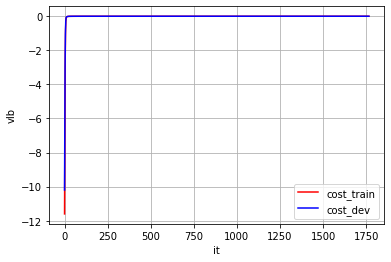

In [16]:
plt.figure()
plt.plot(np.clip(vlb_train[:curr_epoch], -1000, 1000), 'r')
plt.plot(np.clip(vlb_val[:curr_epoch], -1000, 1000), 'b')
plt.legend(['cost_train', 'cost_dev'])
plt.ylabel('vlb')
plt.xlabel('it')
plt.grid(True)
#plt.savefig( str(dname) + '_vlb_lr_' + str(model.lr) + '.png')

In [16]:
#"""
total_parameters = 0
for variable in under_VAEAC_net.trainable_variables:
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    #print(shape)
    #print(len(shape))
    variable_parameters = 1
    for dim in shape:
        #print(dim)
        variable_parameters *= dim
    #print(variable_parameters)
    total_parameters += variable_parameters
print(total_parameters)

#"""

827897


In [5]:
import numpy as np
print(np.load("./COMPAS_VAEAC/compas_vlb_train_lr_0.0001.npy"))

[-6.73977529 -5.61497819 -4.62562061 ...  0.          0.
  0.        ]


In [18]:
#print(under_VAEAC_net.trainable_variables)

In [19]:
#print(model2.decoder.summary())

In [26]:
# TO check the that the parameters in the VAEAC are not trained during the training of under_VAEAC

# Encoder
#print(model2.recognition_encoder.trainable_variables[0])

# Decoder
#print(model2.decoder.trainable_variables[0])

In [27]:
# Encoder
"""
model2 = VAEAC_gauss_cat(width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer_VAEAC, save_model = True)
model2.recognition_encoder = keras.models.load_model("./COMPAS_VAEAC/compas_recog_encoder_lr_0.0001")
print(model2.recognition_encoder.trainable_variables[0])
"""

# Decoder
"""
model2 = VAEAC_gauss_cat(width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer_VAEAC, save_model = True)

model2.decoder = keras.models.load_model("./COMPAS_VAEAC/compas_decoder_lr_0.0001")

print(model2.decoder.trainable_variables[0])
"""


'\nmodel2 = VAEAC_gauss_cat(width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer_VAEAC, save_model = True)\n\nmodel2.decoder = keras.models.load_model("./COMPAS_VAEAC/compas_decoder_lr_0.0001")\n\nprint(model2.decoder.trainable_variables[0])\n'

In [22]:
#print(model2.prior_encoder.summary())

In [23]:
#print(under_VAEAC_net.decoder.summary())

In [24]:
#print(under_VAEAC_net.recognition_encoder.summary())

In [ ]:
### Currently Working on ###

### TODO ###

# Make code work for only continous data (GaussianLogLike?)

# Train VAEAC (default credit) using 7e-4 lr and save the model

# Clean up the code

## eval/training mode things ##

# Verify if BatchNorm does what it should when training = True/False is not sent into the model

# Do I need to set the models to eval mode and not training during validation data or does tf handle this?
    # Apparently batchnorm layers do different things during training/evaluation
    # Adding training = True affects a lot..., it is not enabled by default during train_step gradient.
    # Setting training = True in eval affects the training_VAE still. 
    # Not using training = True/False makes the model work well, 
    # Question is if BatchNorm does the correct thing during eval

##---------------------------##


## Ask Ali 
    # If His network has the correct structure (The decoder was wrong for VAEAC)
    # If He has thought of initlialisations
    # hyperparameters, bias, epsilon, momentum etc.
    # Where are the batches?

# Skip connections from prior to decoder? I don't think CLUE got this to work properly...
    # Memory layer is used in Tf2 github

# Not sure what the TF equivalence of affine and track_running_stats is in Torch BatchNorm1D 
    
# Why does train_step only print things inside it twice for the first batch and then never for any other batch?
    
### TO IMPLEMENT ###


### DONE ###
"""

√ under_VAEAC updates the VAEAC recognition_encoder parameters. Need to freeze them somehow...
    # Maybe calculate proposal_params_VAEAC before calling train_step_under_VAEAC to make it work?
    # Yup, that did the trick

√ Something wrong with the number of trainable parameters in my under_VAEAC? Seems to be way more than in Torch?
    # The VAEAC recognition_encoder was being trained in under_VAEAC

√ Make VAEAC work for COMPAS
    # How to load COMPAS?

√ Train the VAEAC for COMPAS

√ Fix the under_VAEAC code  (i.e. get eval to work there just as in VAEAC)

√ update_train VAE with the train_VAEAC code (Add Shuffle among many things)

√ Plot the loss graph over train and validation set

√ Save the vlb_train & vlb_val after training

√ rec_los: Should the target not be flattened but instead just x_batch?
    # Don't think so, the final values look fairly similar.
    # I think it is fine since the program seems to be doing what it should

√ How do the batches work in the network? How can we send a 64x31 batch to encoder? It should only take 31 as input
    # the keras.input((31, )) means it expect features with dimension 31 and unspecified batch_size. 
    # When a batch with 64,31 size comes it in will treat each row as a sample

√ Should I have 7e-4 or 1e-4 learning rate?
    # 7e-4 for comparing and making sure the model works as intended but 1e-4 for the real training

√ Remove reparametrize?

√ Add lr to print epoch in VAEAC training

√ Is something wrong with the trainable variables? Should I before training use tf.Variable to make them trainable?
    # https://www.tensorflow.org/api_docs/python/tf/Variable
    # Seems right, it is the exact same amount of trainable parameters in torch and tf

√ Have I forgotten to do a tf.reduce_sum over regularisation? 
    # Don't think so... their sum(-1) on reg_cost does nothing

√ Something might be wrong with how the training is done with batches... 
    # Probably not, input(shape,) makes it so that it expects one dimension to be of shape 
    # without specifying the batch size

√ vlb_val is calculated using eval not fit

√ Add shuffling of the training data 

√ Verify the number of trainable parameters in CLUE vs TF 
    # Exact same amount for under_VAEAC and VAEAC

√ implement under_VAEAC vlb (MSELoss and KL-divergence)

√ rsample instead of sample? (rsample for derivatives in torch, tf does not care)

√ Save the model during training (best vlb)

√ Fix so that training with 2nd lvl VAE is done without the mask

√ 1e-4 can at times get very poor vlb at the start but then recover. Why is this?   
    # Seems to have been solved by initialising the dense weights and bias weights the same way as Torch
    # I get like -19 or -20, -22 every single first epoch now

√ Validation vlb not low enough? 
    # Not terrible but indeed not as low, seems to go towards the right values at least but it happens slowly

√ Need to initialise the weights in keras dense for the neurons and bias the same way as nn.linear

√ Need to make the layers in a skip connection sequential? nn.sequential in torch
    # The russian doll effect does exactly this!
    
√ What activation is used in dense/nn.linear?
    # None
    
√ Is keras dense and torch nn.linear the same thing?
    # How are the weights inited in each? (Different ways by default but I made them init the same way)
    # They are basically the same, input to neural network nodes (bias = True add a bias node)
    # Google images for keras dense and nn.linear and you see that it is just a normal feed forward process.
"""